# Coursera Capstone - Characteristics of car accidents and their impact on police, ambulance and fire brigades

## Table of contents:

1. Introduction Section
    - Scenario and background
    - Problem to be solved
    - Recipients of the report
2. Data Section
    - Data required to resolve the problem and how the data will be used to solve the problem
3. Methodology Section
4. Result Section
5. Discussion Section
6. Conslusion Section


## 1. Introduction Section

### Scenario and background
Observing the statistics of car accidents in Seatlle, I came to the conclusion that it is possible to prepare services such as the police, fire brigade or ambulance in advance for serious cases of road accidents involving a large number of people and which may result from weather conditions in specific places of Seattle.

### Problem to be solved
The challenge to be solved is to properly prepare and inform the police, fire brigade and ambulance in advance about the possibility of very serious road accidents depending on the prevailing road conditions in specific places. Therefore, I want to find accidents with the following assumptions:
- Severity is a minimum of 2
- More than 4 are injured, including pedestrians and cyclists
- Depending on the weather condition and road condition
- Depending on the time of day
- Cases resulting from the use of alcohol and other intoxicants are rejected as not resulting directly from weather factors.

### Recipients of the report
I believe that this is a suitable project for a major city security center in Europe, the United States or Asia, as the approach and methodology used here will help prepare services such as the police, fire brigade or hospitals in advance for emergencies (e.g. severe road accidents) from weather conditions.

## 2. Data Section

### Data required to resolve the problem and how the data will be used to solve the problem
The data will be used as follows: First, I sort out the data for which the UNDERINFL parameter (meaning under the influence of intoxicants) is empty or equal to 1 or Y. Thanks to this, I will separate the cases not directly related to the weather conditions, which is based on my assumptions. Then I will sort the data by the SEVERITYCODE attribute for which the minimum value is 2 which will give me only the cases with injuries.
In the next step, I will sort by the number of people participating in the event (PERSONCOUNT) for a minimum value of 4 people and then group them depending on weather conditions (WEATHER), road condition (ROADCOND) and time of day (LIGHTCOND). Finally, I will use the location data (X and Y) to plot the most frequent crash sites on the Seatlle map so the services will know exactly the accidents can happen on particular weather and day conditions.

## 3. Methodology
The paragraph below describes the individual components of the report in which data is collected, prepared and processed, in accordance with the adopted strategy.

### Data extraction and cleaning

In [2]:
import pandas as pd
import requests
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install folium==0.5.0
import folium

import json
import requests
from pandas.io.json import json_normalize

print('Lib were Imported')

     |████████████████████████████████| 81kB 7.0MB/s eta 0:00:011
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
Lib were Imported


In [3]:
!wget -O Data-Collisions.csv https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

--2020-09-21 09:58:47--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 67.228.254.196
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73917638 (70M) [text/csv]
Saving to: ‘Data-Collisions.csv’

100%[======================================>] 73,917,638  36.2MB/s   in 1.9s   

2020-09-21 09:58:49 (36.2 MB/s) - ‘Data-Collisions.csv’ saved [73917638/73917638]



In [4]:
df_raw = pd.read_csv('Data-Collisions.csv')

In [5]:
len(df_raw)

194673

The file contains the information about 194673 collisions which happens at Seatlle. Now we will drop the columns not relevant to our analysis.

In [6]:
df_raw = df_raw.dropna(subset = ['UNDERINFL'])
df_raw = df_raw.dropna(subset = ['X'])
df_raw = df_raw.dropna(subset = ['Y'])

In [7]:
df_acc = df_raw[['SEVERITYCODE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDTTM', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'X', 'Y']]

Now let's check the value types for the column UNDERINFL. Then we will need to normalize the values for this column before the grouping.

In [8]:
df_acc['UNDERINFL'].value_counts(normalize=True)

N    0.528916
0    0.422975
Y    0.027096
1    0.021013
Name: UNDERINFL, dtype: float64

In [9]:
df_acc['UNDERINFL'].replace(to_replace = ['1','0'], value = [1,0], inplace = True)
df_acc['UNDERINFL'].replace(to_replace = ['Y','N'], value = [1,0], inplace = True)
df_acc['UNDERINFL'].value_counts(normalize=True)

0    0.951891
1    0.048109
Name: UNDERINFL, dtype: float64

Now let's normalize the LIGHTCOND column. I assume two states for it - Daylight and Dark.

In [10]:
df_acc['DAYLIGHT'] = df_acc['LIGHTCOND']
df_acc['DAYLIGHT'].value_counts(normalize=True)

Daylight                    0.616198
Dark - Street Lights On     0.256685
Unknown                     0.067445
Dusk                        0.031330
Dawn                        0.013140
Dark - No Street Lights     0.007872
Dark - Street Lights Off    0.006250
Other                       0.001020
Dark - Unknown Lighting     0.000060
Name: DAYLIGHT, dtype: float64

In [11]:
def was_daylight(condition):
    if condition != 'Daylight':
        return 0
    else:
        return 1

df_acc['DAYLIGHT'] = df_acc['DAYLIGHT'].apply(was_daylight)

In [12]:
df_acc['DAYLIGHT'].value_counts(normalize=True)

1    0.61528
0    0.38472
Name: DAYLIGHT, dtype: float64

Next, let's do the same trick with WEATHER and ROADCOND columns. I would like to have them divided as good weather/ bad weather and good road condition/ bad road condition. I assume the dry / clear condition is the possitive and rest are negative values.

In [13]:
df_acc['GOOD_WEATHER'] = df_acc['WEATHER']
df_acc['GOOD_WEATHER'].value_counts(normalize=True)

Clear                       0.590839
Raining                     0.173604
Overcast                    0.147147
Unknown                     0.075336
Snowing                     0.004848
Other                       0.004192
Fog/Smog/Smoke              0.002999
Sleet/Hail/Freezing Rain    0.000607
Blowing Sand/Dirt           0.000271
Severe Crosswind            0.000130
Partly Cloudy               0.000027
Name: GOOD_WEATHER, dtype: float64

In [14]:
def was_good_weather(condition):
    if condition != 'Clear':
        return 0
    else:
        return 1

df_acc['GOOD_WEATHER'] = df_acc['GOOD_WEATHER'].apply(was_good_weather)

In [15]:
df_acc['GOOD_WEATHER'].value_counts(normalize=True)

1    0.590237
0    0.409763
Name: GOOD_WEATHER, dtype: float64

In [16]:
df_acc['GOOD_ROAD'] = df_acc['ROADCOND']
df_acc['GOOD_ROAD'].value_counts(normalize=True)

Dry               0.661727
Wet               0.249695
Unknown           0.075016
Ice               0.006380
Snow/Slush        0.005361
Other             0.000634
Standing Water    0.000553
Sand/Mud/Dirt     0.000347
Oil               0.000287
Name: GOOD_ROAD, dtype: float64

In [17]:
def was_good_road(condition):
    if condition != 'Dry':
        return 0
    else:
        return 1

df_acc['GOOD_ROAD'] = df_acc['GOOD_ROAD'].apply(was_good_road)

In [18]:
df_acc['GOOD_ROAD'].value_counts(normalize=True)

1    0.661293
0    0.338707
Name: GOOD_ROAD, dtype: float64

In [19]:
df_acc = df_acc.drop(columns=['WEATHER','ROADCOND','LIGHTCOND'])

In [20]:
df_acc = df_acc[['SEVERITYCODE','UNDERINFL','DAYLIGHT','GOOD_WEATHER','GOOD_ROAD','PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDTTM', 'X', 'Y']]

In [21]:
len(df_acc)

184602

In [22]:
# Dropping the accidents with severity smaller than 2
df_acc = df_acc.drop(df_acc[df_acc.SEVERITYCODE < 2].index)

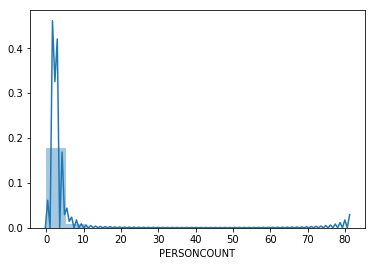

In [23]:
#Check the statistics of the persons which attend the accidents
sns.distplot(df_acc['PERSONCOUNT'], bins=15)

In [24]:
# Dropping the accidents with casaulties less than 4
df_acc = df_acc.drop(df_acc[df_acc.PERSONCOUNT < 4].index)

In [25]:
# Filtering for the night accidents
df_night = df_acc.drop(df_acc[df_acc.DAYLIGHT < 1].index)

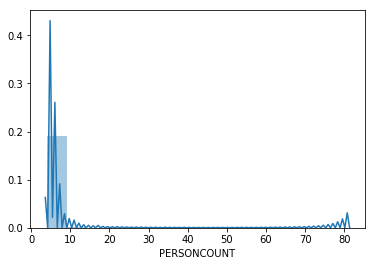

In [26]:
#Check the statistics of the persons which attend the accidents but in night
sns.distplot(df_night['PERSONCOUNT'], bins=15)

In [27]:
len(df_night)

7643

In [28]:
# Filtering for the bad weather accidents
df_bad_weather = df_night.drop(df_night[df_night.GOOD_WEATHER < 1].index)
len(df_bad_weather)

5313

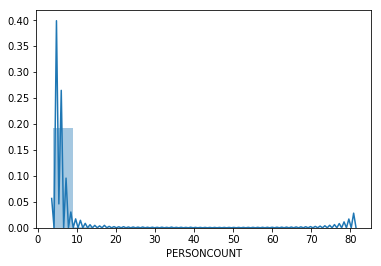

In [29]:
#Check the statistics of the persons which attend the accidents in night and 
sns.distplot(df_bad_weather['PERSONCOUNT'], bins=15)

## 4. Result section
Let's consolidate all the required informations to make final suggestions to Town's Security Service

In [37]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: RT50UFZKHZ2HT3UKHOEJVBEF4RV2ILAWPXCNXGZJGBZMJLOW
CLIENT_SECRET: I5W2A1NSD4HZJXJ52NRHNEUMBDGO0YVYTAWB20DKLOYQRCQ4


In [43]:
radius = 7000 
LIMIT = 1

# The final number of Emergency Stations has been limited to 100 due to the limitations in calling the Foursquare API
def getNearbyEmergencies(radius=2500, searchType='emergency'):
    emgs_list=[]
    tst_loop_counter = 0;
    for lat, lng in zip(df_bad_weather['Y'], df_bad_weather['X']):
        if tst_loop_counter >= 100:
            break
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            searchType,
            radius, 
            LIMIT)
            
        # making GET request
        emg_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby emergency
        emgs_list.append([(
            lat, 
            lng, 
            e['venue']['name'], 
            e['venue']['location']['lat'], 
            e['venue']['location']['lng']) for e in emg_results])
        tst_loop_counter = tst_loop_counter + 1

    nearby_emg = pd.DataFrame([item for emg_list in emgs_list for item in emg_list])
    nearby_emg.columns = ['Accident Latitude', 
                  'Accident Longitude', 
                  'Emergency Name', 
                  'Emergency Latitude', 
                  'Emergency Longitude']
    
    return(nearby_emg)

In [44]:
nearby_em = getNearbyEmergencies()
nearby_em.head()

,Accident Latitude,Accident Longitude,Emergency Name,Emergency Latitude,Emergency Longitude
0,47.571420,-122.328270,VA Medical Center Emergency Department,47.563790,-122.310071
1,47.708535,-122.313786,Twans Emergency Room,47.714547,-122.311730
2,47.566405,-122.306705,VA Medical Center Emergency Department,47.563790,-122.310071
3,47.620903,-122.346296,ZOOM+Care,47.614010,-122.346085
4,47.708569,-122.319209,Twans Emergency Room,47.714547,-122.311730


In [47]:
nearby_em

,Accident Latitude,Accident Longitude,Emergency Name,Emergency Latitude,Emergency Longitude
0,47.571420,-122.328270,VA Medical Center Emergency Department,47.563790,-122.310071
1,47.708535,-122.313786,Twans Emergency Room,47.714547,-122.311730
2,47.566405,-122.306705,VA Medical Center Emergency Department,47.563790,-122.310071
3,47.620903,-122.346296,ZOOM+Care,47.614010,-122.346085
4,47.708569,-122.319209,Twans Emergency Room,47.714547,-122.311730
5,47.670539,-122.378883,Swedish Ballard ER,47.668006,-122.380696
6,47.665035,-122.338087,ZOOM+Care,47.662485,-122.312791
7,47.580853,-122.329056,VA Medical Center Emergency Department,47.563790,-122.310071
8,47.529358,-122.334256,Neighborcare Health Georgetown Dental Clinic,47.547542,-122.315861
9,47.625593,-122.367024,Bayside Family Physicians,47.629135,-122.341904


In [51]:
len(nearby_em)

nearby_em_gruoped = nearby_em.groupby(['Emergency Name']).mean().reset_index()
nearby_em_gruoped

#List of an nearby Emergency Stations which needs to be prepared for casaulties during the night and bad weather conditions

,Emergency Name,Accident Latitude,Accident Longitude,Emergency Latitude,Emergency Longitude
0,Bayside Family Physicians,47.625325,-122.350129,47.629135,-122.341904
1,Care Clinic at Bartell Drugs,47.674849,-122.304700,47.663863,-122.296602
2,Harborview Medical Center,47.601939,-122.330902,47.604167,-122.324138
3,"Jahyun Koo, DDS",47.564720,-122.386772,47.553189,-122.387503
4,Mental Health and Addiction Services at Harbor...,47.602188,-122.316782,47.605644,-122.321014
5,Neighborcare Health Georgetown Dental Clinic,47.538210,-122.334551,47.547542,-122.315861
6,Swedish Ballard ER,47.676441,-122.369518,47.668006,-122.380696
7,Swedish Medical Center - Cherry Hill Emergency...,47.604902,-122.298584,47.607349,-122.311054
8,Twans Emergency Room,47.712048,-122.310784,47.714547,-122.311730
9,VA Medical Center Emergency Department,47.568497,-122.311631,47.563790,-122.310071


In [55]:

latitude_x = 47.54
longitude_y = -122.32
map_Seattle = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng in zip(nearby_em_gruoped['Emergency Latitude'], nearby_em_gruoped['Emergency Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=25,
        popup=None,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Seattle)

map_Seattle

In [56]:
# The final number of Police Stations has been limited to 100 due to the limitations in calling the Foursquare API
def getNearbyPoliceStations(radius=2500, searchType='police'):
    police_list=[]
    tst_loop_counter = 0;
    for lat, lng in zip(df_bad_weather['Y'], df_bad_weather['X']):
        if tst_loop_counter >= 100:
            break
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            searchType,
            radius, 
            LIMIT)
            
        # making GET request
        police_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby police station
        police_list.append([(
            lat, 
            lng, 
            e['venue']['name'], 
            e['venue']['location']['lat'], 
            e['venue']['location']['lng']) for e in police_results])
        tst_loop_counter = tst_loop_counter + 1

    nearby_plc = pd.DataFrame([item for plc_list in police_list for item in plc_list])
    nearby_plc.columns = ['Accident Latitude', 
                  'Accident Longitude', 
                  'PoliceS Name', 
                  'PoliceS Latitude', 
                  'PoliceS Longitude']
    
    return(nearby_plc)

In [57]:
# Getting the nearby police stations which needs to be prepared in case of night and bad weather conditions
nearby_plc_night_bw = getNearbyPoliceStations()

In [59]:
len(nearby_plc_night_bw)

nearby_plc_night_bw_gruoped = nearby_plc_night_bw.groupby(['PoliceS Name']).mean().reset_index()
nearby_plc_night_bw_gruoped

#List of an nearby Police Stations which needs to be prepared for casaulties during the night and bad weather conditions

,PoliceS Name,Accident Latitude,Accident Longitude,PoliceS Latitude,PoliceS Longitude
0,312 Seattle Outpost,47.623454,-122.364335,47.613186,-122.346592
1,King County Sheriff’s - PMU,47.561498,-122.322691,47.561680,-122.324762
2,King County Sherriff's Office,47.525479,-122.273719,47.529816,-122.286371
3,Magnum Storage,47.673646,-122.376249,47.667524,-122.385738
4,NOS Storage,47.529358,-122.334256,47.530923,-122.334151
5,Northgate Self Storage,47.710960,-122.308553,47.707788,-122.318463
6,Outside Storage,47.654152,-122.356039,47.655857,-122.375920
7,Police Station Building C,47.584921,-122.308566,47.582985,-122.323235
8,Seattle Cold Storage,47.541576,-122.335407,47.543071,-122.329627
9,Seattle Police Athletic Association,47.509692,-122.260338,47.503488,-122.286961


In [60]:
latitude_x = 47.54
longitude_y = -122.32
map_Seattle = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng in zip(nearby_plc_night_bw_gruoped['PoliceS Latitude'], nearby_plc_night_bw_gruoped['PoliceS Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=25,
        popup=None,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Seattle)

map_Seattle